# Define Running Mode

- 'full_dataset = True' to use the full data set. If 'full_dataset = True', then a data set containing only data one year of the hobbies sales in TX2.  
    
- 'submit_to_kaggle = True' to submit the forecasts to Kaggle.  


In [1]:
full_dataset = True
submit_to_kaggle = False


# Import Packages

In [1]:
import sys
sys.path.append('..')
import utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import time
from sklearn.metrics import mean_squared_error
import lightgbm as lgb

# Data Import and Preparation

In [3]:
if full_dataset:
    prefix = 'full_dataset_v2'
else:
    prefix = 'subset_v2'

df_merged = pd.read_csv(
    f'{utils.get_m5_root_dir()}/data/feature_engineering/{prefix}_df_merged.csv')

scaling_factors_rmsse = pd.read_csv(
    f'{utils.get_m5_root_dir()}/data/weights/scaling_factors_rmsse.csv')

weights_wrmsse = pd.read_csv(
    f'{utils.get_m5_root_dir()}/data/weights/weights_for_wrmsse.csv')


In [4]:
# downcast numerical values to reduce mem usage
df_merged = utils.reduce_mem_usage(df_merged)

Mem. usage of decreased to 5936.47 Mb (62.8% reduction)


# Delete Data where Item was not up for Sale

Item is not up for sale when price is NA.

In [5]:
print(df_merged.shape)

df_merged = df_merged.loc[df_merged['sell_price'] > 0]

print(df_merged.shape)

(53662400, 39)
(44307636, 39)


# Model Training & Forecasting (LightGBM)

In [6]:
# Custom Loss & valid for asymetric rmse
def custom_mse_asymmetric_loss(y_pred, y_true):
    y_true = y_true.get_label()
    residual = (y_true - y_pred).astype("float")
    grad = np.where(residual < 0, -2 * residual, -2 * residual * 1.1)
    hess = np.where(residual < 0, 2, 2 * 1.1)
    return grad, hess


def custom_rmse_asymmetric_valid(y_pred, y_true, tmp=None):
    y_true = y_true.get_label()
    residual = (y_true - y_pred).astype("float")
    loss = np.where(residual < 0, (residual ** 2), (residual ** 2) * 1.1)
    return "custom_mse_asymmetric_eval", np.sqrt(np.mean(loss)), False

In [7]:
# TODO: proper feature selection (e.g. random forrest)
# for now: hardcoded list of features


cat_features = [
    'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'year', 'month',
    'day', 'is_weekend', 'wday', 'event_name_1', 'event_type_1',
    'event_name_2', 'event_type_2', 'snap_CA', 'snap_TX', 'snap_WI',
    'up_for_sale'
]

num_features = [
    'sell_price',
    'rolling_mean_t28_s7', 'rolling_mean_t28_s1', 'rolling_mean_t7_s7',
       'rolling_mean_t7_s1', 'rolling_std_t28_s7', 'rolling_kurt_t28_s7',
       'rolling_skew_t28_s7', 'lag_t28', 'lag_t7', 'lag_t1',
    'price_change_t1', 'price_change_t30', 'rolling_price_std_t28'
]

features = cat_features + num_features

In [8]:
x_train = df_merged[df_merged['date'] <= '2016-03-27'][features]
y_train = df_merged[df_merged['date'] <= '2016-03-27']['sale']


x_val = df_merged.loc[df_merged['data_type'] ==
                      'train'].loc[df_merged['date'] > '2016-03-27'][features]
y_val = df_merged.loc[df_merged['data_type'] ==
                      'train'].loc[df_merged['date'] > '2016-03-27']['sale']

# keep date here, drop later
x_pred = df_merged[(df_merged['data_type'] == 'validation')][features]


print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_pred.shape)

(42600196, 32)
(42600196,)
(853720, 32)
(853720,)
(853720, 32)


In [9]:
# create datasets
train_data = lgb.Dataset(x_train, label=y_train,
                         categorical_feature=cat_features, free_raw_data=False,
                       )
validation_data = lgb.Dataset(
    x_val, label=y_val, categorical_feature=cat_features, free_raw_data=False, reference=train_data,
)

In [10]:
params = {
    'boosting_type': 'gbdt',
    #'objective': 'regression',
    #'objective': 'poisson',
    #'tweedie_variance_power': 1.1,
    #'metric': 'rmse',
    'seed': 10,
    'learning_rate': 0.25,
    'bagging_fraction': 0.75,
    'bagging_freq': 10,
    'max_bin': 128,
    'feature_fraction ': 0.75,
}

evals_result = {}  # to record eval results for plotting

gbm = lgb.train(params, train_data, valid_sets=[train_data, validation_data],
                evals_result=evals_result, num_boost_round=1000,
                verbose_eval=25, early_stopping_rounds=20,
                fobj=custom_mse_asymmetric_loss,
                feval=custom_rmse_asymmetric_valid
               )




c:\users\domin\anaconda3\envs\predicting-sales-data\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[25]	training's custom_mse_asymmetric_eval: 2.31696	valid_1's custom_mse_asymmetric_eval: 1.9814
[50]	training's custom_mse_asymmetric_eval: 2.28382	valid_1's custom_mse_asymmetric_eval: 1.97337
[75]	training's custom_mse_asymmetric_eval: 2.26164	valid_1's custom_mse_asymmetric_eval: 1.96731
[100]	training's custom_mse_asymmetric_eval: 2.24402	valid_1's custom_mse_asymmetric_eval: 1.96389
[125]	training's custom_mse_asymmetric_eval: 2.23182	valid_1's custom_mse_asymmetric_eval: 1.9619
[150]	training's custom_mse_asymmetric_eval: 2.21987	valid_1's custom_mse_asymmetric_eval: 1.95901
[175]	training's custom_mse_asymmetric_eval: 2.20971	valid_1's custom_mse_asymmetric_eval: 1.95893
Early stopping, best iteration is:
[163]	training's custom_mse_asymmetric_eval: 2.21395	valid_1's custom_mse_asymmetric_eval: 1.95868


In [12]:
def forecast_iteratively(data='pred'):

    print('***** Startup *****')

    if data == 'pred':
        date_1 = '2016-04-25'

    elif data == 'val':
        date_1 = '2016-03-28'

    else:
        raise ValueError("'data not in ['pred', 'val']")

    forecasts = []

    # redude size of df to speed up
    df_tmp = df_merged.loc[df_merged['date'] >= str(
        pd.to_datetime(date_1).date() -
        pd.to_timedelta(40, unit='d'))].loc[df_merged['date'] <= str(
            pd.to_datetime(date_1).date() +
            pd.to_timedelta(28, unit='d'))].copy()

    df_tmp['y_pred'] = np.nan

    c = 0
    for day_i in range(28):

        print(f'\n***** Predict day {day_i + 1} *****')

        df_tmp['rolling_mean_t28_s7'] = df_tmp.groupby(
            ['id'])['sale'].transform(lambda x: x.shift(7).rolling(28).mean())

        df_tmp['rolling_mean_t28_s1'] = df_tmp.groupby(
            ['id'])['sale'].transform(lambda x: x.shift(1).rolling(28).mean())

        df_tmp['rolling_mean_t7_s7'] = df_tmp.groupby(
            ['id'])['sale'].transform(lambda x: x.shift(7).rolling(7).mean())

        df_tmp['rolling_mean_t7_s1'] = df_tmp.groupby(
            ['id'])['sale'].transform(lambda x: x.shift(1).rolling(7).mean())

        df_tmp['rolling_std_t28_s7'] = df_tmp.groupby(
            ['id'])['sale'].transform(lambda x: x.shift(7).rolling(28).std())

        df_tmp['rolling_kurt_t28_s7'] = df_tmp.groupby(
            ['id'])['sale'].transform(lambda x: x.shift(7).rolling(28).kurt())

        df_tmp['rolling_skew_t28_s7'] = df_tmp.groupby(
            ['id'])['sale'].transform(lambda x: x.shift(7).rolling(30).skew())

        df_tmp['lag_t28'] = df_tmp.groupby(
            ['id'])['sale'].transform(lambda x: x.shift(28))

        df_tmp['lag_t7'] = df_tmp.groupby(
            ['id'])['sale'].transform(lambda x: x.shift(7))

        df_tmp['lag_t1'] = df_tmp.groupby(
            ['id'])['sale'].transform(lambda x: x.shift(1))

        date_i = pd.to_datetime(date_1).date() + pd.to_timedelta(day_i,
                                                                 unit='d')
        
        df_tmp.loc[df_tmp.date == str(date_i), 'sale'] = gbm.predict(
            df_tmp.loc[df_tmp.date == str(date_i)][features])


    if data == 'val':
        preds = df_tmp.loc[df_tmp['data_type'] == 'train'].loc[
            df_tmp['date'] > '2016-03-27'][['id', 'year', 'month', 'day', 'sale']]
    if data == 'pred':
        preds = df_tmp[(df_tmp['data_type'] == 'validation')][['id', 'year', 'month', 'day', 'sale']]

    preds = preds.rename(columns={'sale': 'y_pred'})
    return preds


y_pred = forecast_iteratively(data='pred')

***** Startup *****

***** Predict day 1 *****

***** Predict day 2 *****

***** Predict day 3 *****

***** Predict day 4 *****

***** Predict day 5 *****

***** Predict day 6 *****

***** Predict day 7 *****

***** Predict day 8 *****

***** Predict day 9 *****

***** Predict day 10 *****

***** Predict day 11 *****

***** Predict day 12 *****

***** Predict day 13 *****

***** Predict day 14 *****

***** Predict day 15 *****

***** Predict day 16 *****

***** Predict day 17 *****

***** Predict day 18 *****

***** Predict day 19 *****

***** Predict day 20 *****

***** Predict day 21 *****

***** Predict day 22 *****

***** Predict day 23 *****

***** Predict day 24 *****

***** Predict day 25 *****

***** Predict day 26 *****

***** Predict day 27 *****

***** Predict day 28 *****


# Training Analysis

Plotting metrics recorded during training...


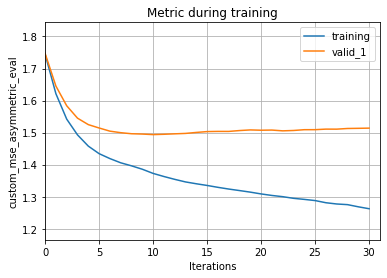

In [16]:
print('Plotting metrics recorded during training...')
ax = lgb.plot_metric(evals_result)
plt.show()

Plotting feature importances...


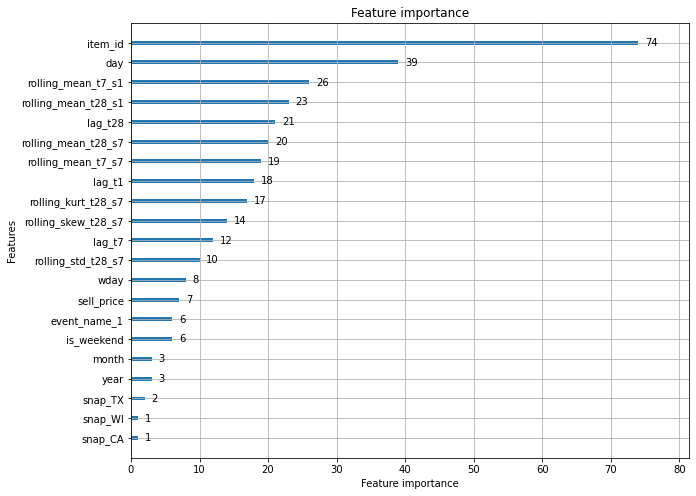

In [17]:
print('Plotting feature importances...')
ax = lgb.plot_importance(gbm, figsize=(10,8))
plt.show()

# Error for different Predicting Intervals

In [20]:
y_val_pred = forecast_iteratively('val')

***** Startup *****

***** Predict day 1 *****

***** Predict day 2 *****

***** Predict day 3 *****

***** Predict day 4 *****

***** Predict day 5 *****

***** Predict day 6 *****

***** Predict day 7 *****

***** Predict day 8 *****

***** Predict day 9 *****

***** Predict day 10 *****

***** Predict day 11 *****

***** Predict day 12 *****

***** Predict day 13 *****

***** Predict day 14 *****

***** Predict day 15 *****

***** Predict day 16 *****

***** Predict day 17 *****

***** Predict day 18 *****

***** Predict day 19 *****

***** Predict day 20 *****

***** Predict day 21 *****

***** Predict day 22 *****

***** Predict day 23 *****

***** Predict day 24 *****

***** Predict day 25 *****

***** Predict day 26 *****

***** Predict day 27 *****

***** Predict day 28 *****


In [23]:
y_val_pred

,id,year,month,day,y_pred
51954960,HOBBIES_1_001_CA_1_validation,2016,3,28,1.024659
51954961,HOBBIES_1_002_CA_1_validation,2016,3,28,0.406754
51954962,HOBBIES_1_003_CA_1_validation,2016,3,28,0.456381
51954963,HOBBIES_1_004_CA_1_validation,2016,3,28,2.442505
51954964,HOBBIES_1_005_CA_1_validation,2016,3,28,0.920281
...,...,...,...,...,...
52808675,FOODS_3_823_WI_3_validation,2016,4,24,0.481152
52808676,FOODS_3_824_WI_3_validation,2016,4,24,0.756242
52808677,FOODS_3_825_WI_3_validation,2016,4,24,1.184475
52808678,FOODS_3_826_WI_3_validation,2016,4,24,1.458618


In [32]:
id_mapping_table = df_merged[['id', 'date','item_id', 'year', 'month', 'day','store_id']].drop_duplicates()
id_mapping_table

,id,date,item_id,year,month,day,store_id
1,HOBBIES_1_002_CA_1_validation,2011-07-29,1438,2011,7,29,0
3,HOBBIES_1_004_CA_1_validation,2011-07-29,1440,2011,7,29,0
4,HOBBIES_1_005_CA_1_validation,2011-07-29,1441,2011,7,29,0
7,HOBBIES_1_008_CA_1_validation,2011-07-29,1444,2011,7,29,0
8,HOBBIES_1_009_CA_1_validation,2011-07-29,1445,2011,7,29,0
...,...,...,...,...,...,...,...
53662395,FOODS_3_823_WI_3_validation,2016-05-22,1432,2016,5,22,9
53662396,FOODS_3_824_WI_3_validation,2016-05-22,1433,2016,5,22,9
53662397,FOODS_3_825_WI_3_validation,2016-05-22,1434,2016,5,22,9
53662398,FOODS_3_826_WI_3_validation,2016-05-22,1435,2016,5,22,9


In [33]:
df_tmp = x_val.copy()
df_tmp = df_tmp.merge(id_mapping_table,
                         on=['item_id', 'store_id', 'year', 'month', 'day'],
                         how='left')
df_tmp = df_tmp.merge(y_val_pred, on=['id','year','month','day'])
df_tmp['y_true'] = y_val.values
df_tmp['error'] = (df_tmp.y_true - df_tmp.y_pred)
df_tmp

,item_id,dept_id,cat_id,store_id,state_id,year,month,day,is_weekend,wday,...,rolling_mean_t7_s1,rolling_std_t28_s7,rolling_kurt_t28_s7,rolling_skew_t28_s7,lag_t28,lag_t7,lag_t1,price_change_t1,price_change_t30,rolling_price_std_t28
51954960,1437,3,1,0,0,2016,3,28,0,3,...,1.142857,1.104943,0.829160,1.161308,0.0,1.0,1.0,0.0,0.0,8.622286e-08
51954961,1438,3,1,0,0,2016,3,28,0,3,...,0.571429,0.417855,0.176224,1.580130,0.0,0.0,1.0,0.0,0.0,0.000000e+00
51954962,1439,3,1,0,0,2016,3,28,0,3,...,0.285714,1.201300,17.652346,3.995593,0.0,0.0,0.0,0.0,0.0,0.000000e+00
51954963,1440,3,1,0,0,2016,3,28,0,3,...,3.571429,1.685214,0.345398,0.880055,0.0,4.0,6.0,0.0,0.0,0.000000e+00
51954964,1441,3,1,0,0,2016,3,28,0,3,...,0.857143,0.944911,-0.505114,0.465895,1.0,2.0,0.0,0.0,0.0,4.434852e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52808675,1432,2,0,9,2,2016,4,24,1,2,...,0.142857,0.524531,11.183432,3.659999,0.0,0.0,0.0,0.0,0.0,7.810822e-08
52808676,1433,2,0,9,2,2016,4,24,1,2,...,0.142857,0.534522,2.494872,1.866548,0.0,0.0,1.0,0.0,0.0,1.872101e-01
52808677,1434,2,0,9,2,2016,4,24,1,2,...,0.571429,1.184110,1.255361,1.392955,1.0,0.0,1.0,0.0,0.0,0.000000e+00
52808678,1435,2,0,9,2,2016,4,24,1,2,...,0.857143,1.070899,0.925521,1.135138,4.0,1.0,1.0,0.0,0.0,0.000000e+00


In [46]:
tmp = df_tmp[['id', 'year', 'month', 'day', 'y_pred', 'y_true', 'error']]
tmp_grouped = tmp.groupby(['year', 'month', 'day'])


for date, row in tmp_grouped:
    
    # compute RMSSE and store it in dict
    rmsse_dict = {}

    for name, group in row.groupby(['id']):

        scale = scaling_factors_rmsse.loc[scaling_factors_rmsse['id'] == name]['scaling_factor'].to_list()[0]
        weight = weights_wrmsse.loc[weights_wrmsse['id'] == name]['weights'].values[0]

        rmsse_dict[name] = [np.sqrt(np.mean(group.error**2 / scale))]
        
        
    # convert dict to dataframe
    rmsse_df = pd.DataFrame(rmsse_dict).T
    rmsse_df['id'] = rmsse_df.index
    rmsse_df = rmsse_df.reset_index(drop=True)
    rmsse_df = rmsse_df.rename(columns={0:'RMSSE'})

    # add weights to df and compute weights multiplied by RMSSE
    rmsse_df = rmsse_df.merge(weights_wrmsse, how='inner')
    rmsse_df['w_times_RMSSE'] = rmsse_df.loc[:,'weights'] * rmsse_df.loc[:,'RMSSE']

    # sort values by their impact
    rmsse_df = rmsse_df.sort_values(by='RMSSE', ascending=False)

    print('WRMSSE of %s = %0.5f' % (date, np.sum(rmsse_df.RMSSE * rmsse_df.weights)))
    # WRMSSE overall = 0.01167

    
    


WRMSSE of (2016, 3, 28) = 0.58501
WRMSSE of (2016, 3, 29) = 0.58158
WRMSSE of (2016, 3, 30) = 0.58108
WRMSSE of (2016, 3, 31) = 0.61067
WRMSSE of (2016, 4, 1) = 0.71390
WRMSSE of (2016, 4, 2) = 0.78234
WRMSSE of (2016, 4, 3) = 0.83476
WRMSSE of (2016, 4, 4) = 0.68801
WRMSSE of (2016, 4, 5) = 0.67024
WRMSSE of (2016, 4, 6) = 0.67690
WRMSSE of (2016, 4, 7) = 0.64581
WRMSSE of (2016, 4, 8) = 0.70476
WRMSSE of (2016, 4, 9) = 0.81764
WRMSSE of (2016, 4, 10) = 0.82042
WRMSSE of (2016, 4, 11) = 0.72404
WRMSSE of (2016, 4, 12) = 0.69283
WRMSSE of (2016, 4, 13) = 0.64348
WRMSSE of (2016, 4, 14) = 0.66503
WRMSSE of (2016, 4, 15) = 0.72286
WRMSSE of (2016, 4, 16) = 0.76308
WRMSSE of (2016, 4, 17) = 0.79380
WRMSSE of (2016, 4, 18) = 0.68590
WRMSSE of (2016, 4, 19) = 0.64745
WRMSSE of (2016, 4, 20) = 0.62908
WRMSSE of (2016, 4, 21) = 0.63255
WRMSSE of (2016, 4, 22) = 0.66678
WRMSSE of (2016, 4, 23) = 0.75034
WRMSSE of (2016, 4, 24) = 0.79539


# Printout Forecasts

In [15]:
# map forecast values to encoded item_ids
y_pred

,id,year,month,day,y_pred
52808680,HOBBIES_1_001_CA_1_validation,2016,4,25,1.020237
52808681,HOBBIES_1_002_CA_1_validation,2016,4,25,0.171892
52808682,HOBBIES_1_003_CA_1_validation,2016,4,25,0.609980
52808683,HOBBIES_1_004_CA_1_validation,2016,4,25,2.028737
52808684,HOBBIES_1_005_CA_1_validation,2016,4,25,1.239496
...,...,...,...,...,...
53662395,FOODS_3_823_WI_3_validation,2016,5,22,0.673190
53662396,FOODS_3_824_WI_3_validation,2016,5,22,0.673190
53662397,FOODS_3_825_WI_3_validation,2016,5,22,0.972431
53662398,FOODS_3_826_WI_3_validation,2016,5,22,1.388250


In [16]:
# create dict with IDs and forecasts
submission_dict = {}

for i, df in y_pred.groupby(['id']):
    df = df.reset_index(drop=True)
    submission_dict[i] = df['y_pred']

In [79]:
# convert dict to dataframe
submission_df = pd.DataFrame(submission_dict).T
submission_df = submission_df.clip(lower=0) # Convert negative values to 0
submission_df.reset_index(level=0, inplace=True)
f_list = [f'F{di}' for di in list(range(1, 29))]
submission_df.columns = ['id'] + f_list
submission_df

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_1_001_CA_1_validation,0.997598,0.925036,0.921305,0.924750,1.052562,1.275913,1.306471,1.141895,1.044709,...,1.122383,1.324017,1.321247,1.069779,0.947012,0.940289,0.938047,1.020627,1.278493,1.275844
1,FOODS_1_001_CA_2_validation,1.356149,1.213751,1.351421,1.359931,1.584798,2.192306,2.060404,1.554765,1.449617,...,1.907614,2.397609,2.511486,1.658776,1.572368,1.565644,1.599818,1.833177,2.443671,2.097195
2,FOODS_1_001_CA_3_validation,0.619549,0.873776,0.852949,0.852949,1.246323,1.409781,1.406718,1.202986,1.167589,...,1.515407,1.719350,1.866108,1.286405,1.179519,1.155700,1.153050,1.352254,1.672802,1.546695
3,FOODS_1_001_CA_4_validation,0.452760,0.336635,0.378148,0.378148,0.473357,0.566243,0.618875,0.466351,0.470460,...,0.601852,0.668306,0.675996,0.600958,0.579063,0.572339,0.569690,0.571420,0.643063,0.640413
4,FOODS_1_001_TX_1_validation,0.071797,0.221639,0.217907,0.217907,0.215797,0.311396,0.345968,0.360224,0.364333,...,0.352201,0.434887,0.450229,0.346990,0.336402,0.329679,0.327029,0.338901,0.428603,0.509602
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,HOUSEHOLD_2_516_TX_2_validation,0.197696,0.246377,0.247538,0.242646,0.276174,0.369608,0.440037,0.329313,0.321802,...,0.366993,0.449679,0.384754,0.287224,0.275351,0.275351,0.272702,0.274432,0.364134,0.358372
30486,HOUSEHOLD_2_516_TX_3_validation,0.103215,0.219291,0.215559,0.215559,0.217290,0.292664,0.338572,0.302226,0.308731,...,0.481836,0.418042,0.425732,0.350694,0.338822,0.346474,0.343824,0.356862,0.512153,0.509503
30487,HOUSEHOLD_2_516_WI_1_validation,0.052424,0.168500,0.164769,0.164769,0.208320,0.293896,0.321745,0.208856,0.295477,...,0.307479,0.390165,0.397855,0.262936,0.251064,0.251064,0.248414,0.299511,0.389213,0.405523
30488,HOUSEHOLD_2_516_WI_2_validation,0.162425,0.207587,0.207375,0.250131,0.178447,0.245963,0.293371,0.304815,0.308924,...,0.277605,0.343732,0.349922,0.274884,0.263012,0.263012,0.260362,0.262092,0.333735,0.342119


# Submit to Kaggle 

In [49]:
df_submission = submission_df.append(
    submission_df.replace(to_replace='validation', value='evaluation',
                          regex=True))
filename = utils.get_m5_root_dir(
) + '/data/submissions/gradient_boosting_regressor_v_2_5.csv'
df_submission.to_csv(filename, index=False)